In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
logon_df = pd.read_csv("C:\\Users\\kim\\Downloads\\r2\\logon.csv")

In [3]:
logon_df.head()

,id,date,user,pc,activity
0,{Q9W7-Z6TD90VH-9722UOQW},1/4/2010 8:47:00,DBT0001,PC-8395,Logon
1,{M0G5-U3UB28KR-1843ZWNN},1/4/2010 11:49:45,DBT0001,PC-8660,Logon
2,{M7T7-A6VZ99JN-1013WISU},1/4/2010 12:44:39,DBT0001,PC-8660,Logoff
3,{J3H6-C7LN75YJ-4291TUHK},1/4/2010 13:22:24,DBT0001,PC-8395,Logon
4,{W9Q2-T1IC68GM-6231DJFO},1/4/2010 15:45:00,DBT0001,PC-8395,Logoff


In [4]:
from datetime import datetime
logon_df['new_date'] = logon_df['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M:%S').strftime("%m/%d/%Y"))

In [5]:
del logon_df['id']
del logon_df['date']

In [6]:
logon_df = logon_df[logon_df['activity']=='Logon']

In [7]:
users = logon_df['user'].unique()

In [8]:
len(users)

1000

In [9]:
def KalmanFilter(group_logons):
    sz = len(group_logons)

    xhat = np.zeros(sz)      # a posteri estimate of x
    P = np.zeros(sz)         # a posteri error estimate
    xhatminus = np.zeros(sz) # a priori estimate of x
    Pminus = np.zeros(sz)    # a prior error estimate
    K = np.zeros(sz)         # Kalman gain

    Q = 10000    # process variance
    R = 200    # estimate of measurement variance
    xhat[0] = 0.0
    P[0] = 1.0

    k = 0
    for index, row in group_logons.iterrows():
        if(k == sz-1):
            break
        k+=1
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + Q

        K[k] = Pminus[k]/(Pminus[k] + R)
        xhat[k] = xhatminus[k] + K[k]*(row['count']-xhatminus[k])
        P[k] = (1-K[k]*Pminus[k]) 
        
    counts = group_logons['count'].as_matrix()
    margin = np.sqrt((counts - xhat)**2)   
    return margin, xhat, counts

User is:  MDH0029


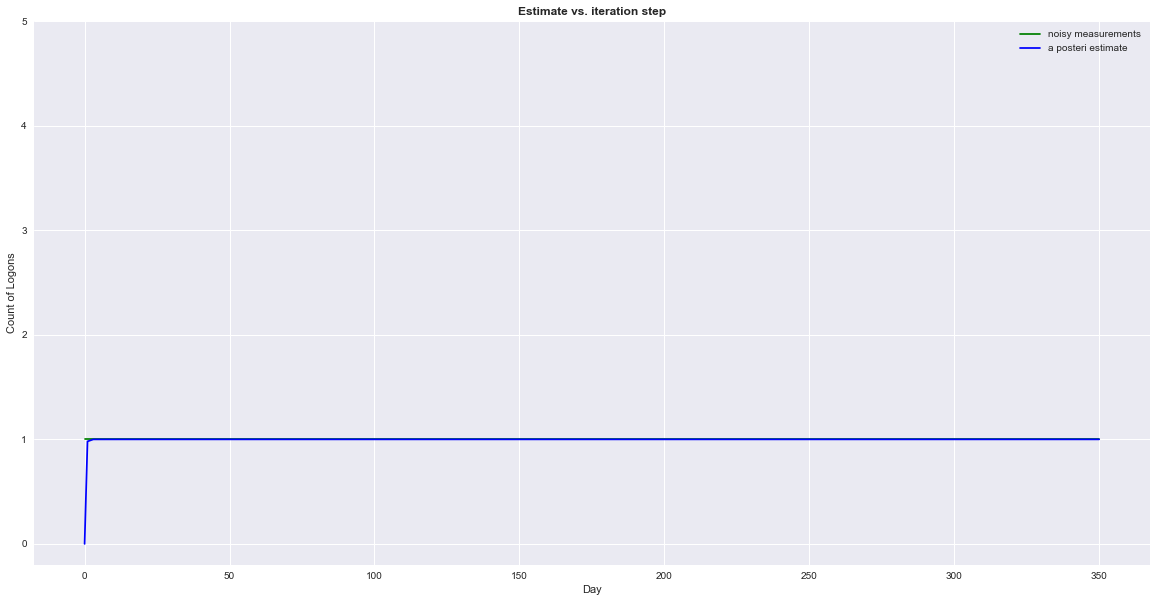

User is:  BWN0227


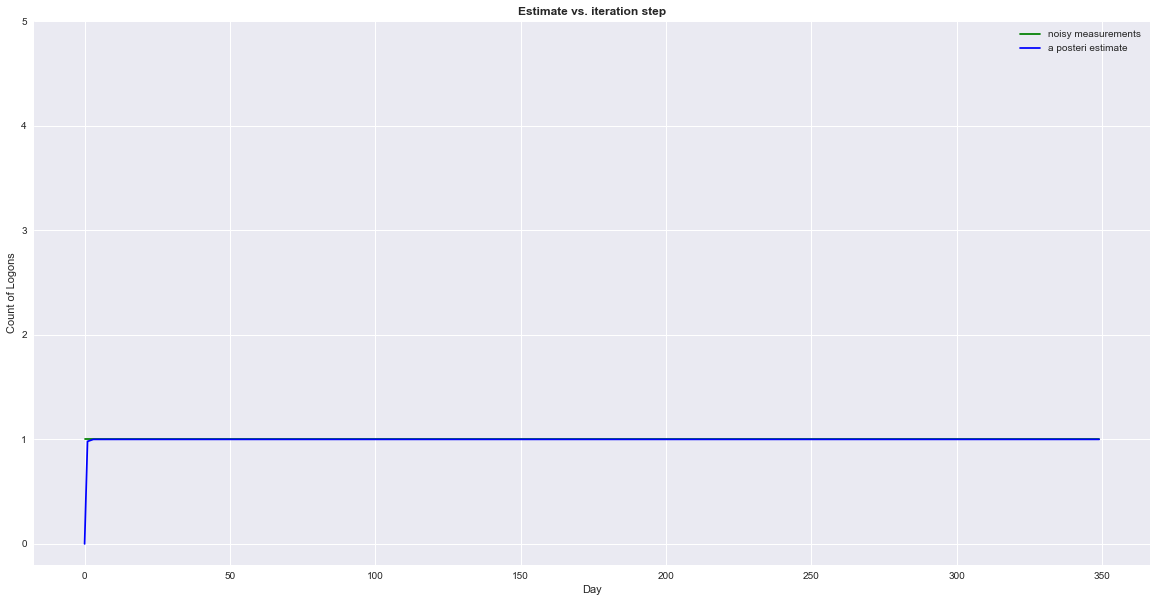

User is:  CCM0531


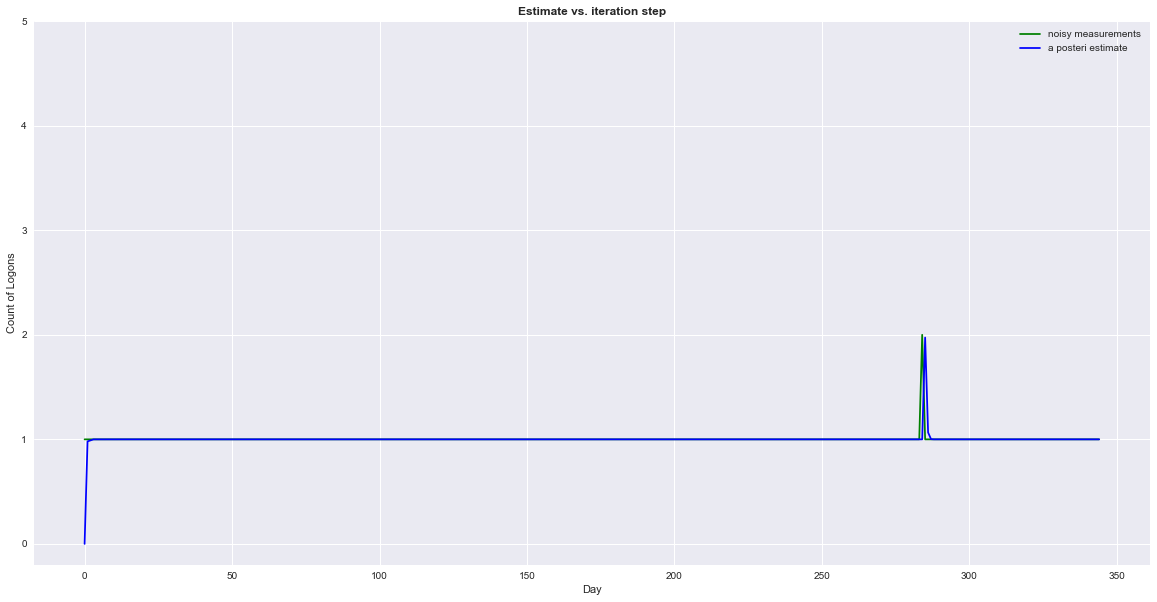

User is:  CTH0881


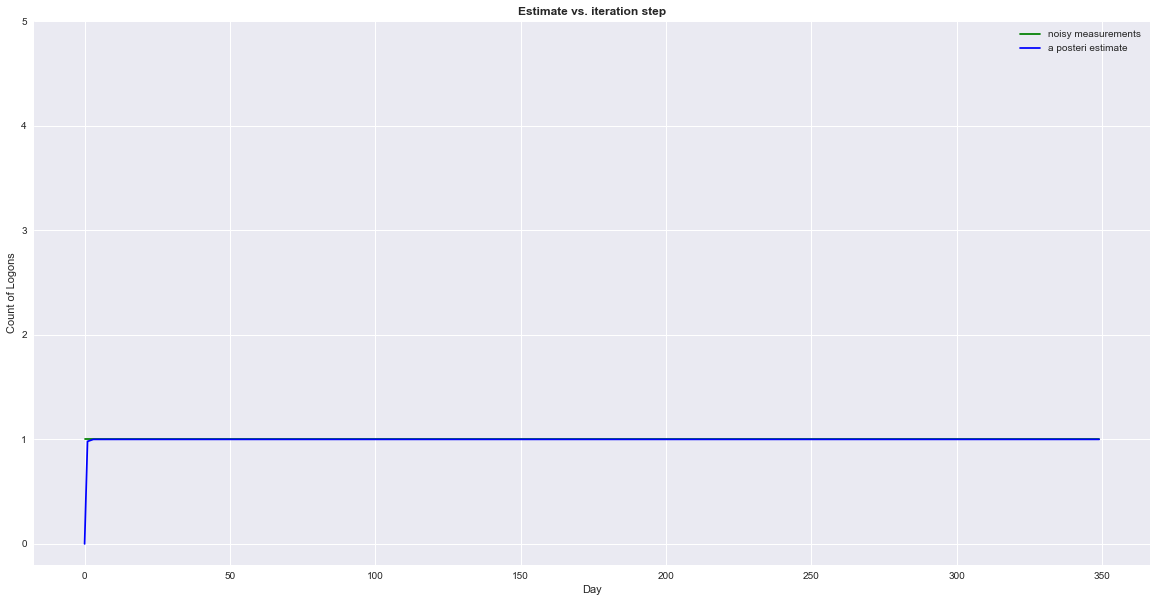

In [16]:
final = pd.DataFrame()
for u in users:
    temp_df = logon_df[logon_df['user']==u]
    group_logons = temp_df.groupby(['new_date'])['pc'].nunique().reset_index()
    group_logons.sort_values(by='new_date')
    
    group_logons.columns=['new_date','count']
    
    if(len(group_logons)>2):
        try:
            margins, xhat2, counts = KalmanFilter(group_logons)
        except:
            continue;
    
        differences = pd.DataFrame(margins)
        differences.columns=['value']

        std_dev = differences['value'].std()
        cutoff = 18.7*differences['value'].std()
        found = group_logons[group_logons['count'].gt(cutoff)]
        if(len(found)) > 0:
            final = final.append([[u, std_dev, found, xhat2]])
            print("User is: ", u)
            plt.figure(figsize=(20,10))
            plt.plot(counts,label='noisy measurements', color='g')
            plt.plot(xhat2,'b-',label='a posteri estimate')
            plt.legend()
            plt.title('Estimate vs. iteration step', fontweight='bold')
            plt.ylim(ymin=-0.2, ymax=5)
            plt.xlabel('Day')
            plt.ylabel('Count of Logons')
            plt.show()
        else:
            final = final.append([[u, std_dev, '0', xhat2]])

In [12]:
counts = group_logons['count'].as_matrix()

In [13]:
final.columns=['user', 'std_dev', 'found','xhat']

In [14]:
final[final['found']!='0']

,user,std_dev,found,xhat
0,MDH0029,0.053384,new_date count 0 01/03/2011 1 ...,"[0.0, 0.980394079012, 0.9900999901, 0.99980403..."
0,BWN0227,0.053461,new_date count 0 01/03/2011 1 ...,"[0.0, 0.980394079012, 0.9900999901, 0.99980403..."
0,CCM0531,0.092224,new_date count 284 10/01/2010 2,"[0.0, 0.980394079012, 0.9900999901, 0.99980403..."
0,CTH0881,0.053461,new_date count 0 01/03/2011 1 ...,"[0.0, 0.980394079012, 0.9900999901, 0.99980403..."


In [ ]:
for index, row in final.iterrows():
    temp_df = logon_df[logon_df['user']==row['user']]
    group_logons = temp_df.groupby(['new_date'])['pc'].nunique().reset_index()
    group_logons.sort_values(by='new_date')
    group_logons.head()

In [ ]:
final['std_dev'].hist()

In [ ]:
final[final['std_dev']>2.2]

In [ ]:
group_logons.head()

In [ ]:
for u in final[final['found']!='0']['user']:
    print("User: ", u)
    temp_df = logon_df[logon_df['user']==u]
    group_logons = temp_df.groupby(['new_date'])['pc'].nunique().reset_index()
    group_logons.sort_values(by='new_date')
    counts = group_logons['count'].as_matrix()
    plt.figure(figsize=(20,10))
    plt.plot(counts,label='noisy measurements', color='g')
    plt.plot(xhat,'b-',label='a posteri estimate')
    plt.legend()
    plt.title('Estimate vs. iteration step', fontweight='bold')
    plt.xlabel('Day')
    plt.ylabel('Count of Logons')

In [ ]:
group_logons.head()

In [ ]:
def KalmanFilterWithPlot(group_logons):
    sz = len(group_logons)

    xhat = np.zeros(sz)      # a posteri estimate of x
    P = np.zeros(sz)         # a posteri error estimate
    xhatminus = np.zeros(sz) # a priori estimate of x
    Pminus = np.zeros(sz)    # a prior error estimate
    K = np.zeros(sz)         # Kalman gain

    Q = 10000    # process variance
    R = 200    # estimate of measurement variance
    xhat[0] = 0.0
    P[0] = 1.0

    k = 0
    for index, row in group_logons.iterrows():
        if(k == sz-1):
            break
        k+=1
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + Q

        K[k] = Pminus[k]/(Pminus[k] + R)
        xhat[k] = xhatminus[k] + K[k]*(row['count']-xhatminus[k])
        P[k] = (1-K[k]*Pminus[k]) 
        
    counts = group_logons['count'].as_matrix()
    margin = np.sqrt((counts - xhat)**2)  
    
    plt.plot(counts,label='noisy measurements', color='g')
    plt.plot(xhat,'b-',label='a posteri estimate')
    plt.legend()
    plt.title('Estimate vs. iteration step', fontweight='bold')
    plt.xlabel('Day')
    plt.ylabel('Count of Logons')
    plt.show()
    
    return margin, xhat, counts

In [ ]:
final = pd.DataFrame()
for u in users:
    temp_df = logon_df[logon_df['user']==u]
    group_logons = temp_df.groupby(['new_date'])['pc'].nunique().reset_index()
    group_logons.sort_values(by='new_date')
    
    group_logons.columns=['new_date','count']
    KalmanFilterWithPlot(group_logons)
    